In [0]:
!pip install ppscore
!pip install catboost
!pip install sweetviz
!pip install --upgrade pandas
!pip install --upgrade numpy

In [182]:
import numpy as np
import pandas as pd
import ppscore as pps
import pickle
from IPython.display import clear_output
import sweetviz
import datetime
import pandas as pd
from pandas_datareader import data
import warnings
from sklearn.model_selection import KFold, cross_val_score,StratifiedKFold
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
import csv
import re
from lightgbm import plot_importance,LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from math import sqrt
from catboost import CatBoostRegressor
from catboost import Pool, cv
import pickle
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')
drive.mount("/GD")

Drive already mounted at /GD; to attempt to forcibly remount, call drive.mount("/GD", force_remount=True).


In [0]:
parse_dates = ['Date']
df_train = pd.read_csv("/..Train.csv",parse_dates=parse_dates)
df_test = pd.read_csv("/..test.csv",parse_dates=parse_dates)



In [0]:
#building up the target customer column,about 435 products were manually labeled by the following code below
train_prods=df_train['Subcategory_2'].tolist()
test_prods=df_test['Subcategory_2'].tolist()
prods=train_prods+test_prods
prods=list(set(prods))

# classifying target customer. Looking at the product I classified them into end user type women,men unisex,baby,kid
d={}
num=0
for item in prods:
  clear_output(wait=False)
  print(str(num))
  print(item)
  i=input("classify ")
  d[str(item)]=str(i)
  num+=1
  

import pickle
with open('/dict.p', 'wb') as fp:
    pickle.dump(d, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
with open('...dict.p', 'rb') as fp:
    x = pickle.load(fp)


In [299]:
#a very powerful eda tool for getting an overview of the data
my_report = sweetviz.compare([df_train.drop(['Date'],axis=1), "Train"], [df_test.drop(['Date'],axis=1), "Test"], "Selling_Price")


                                   |                         | [  0%]   00:00  -> (? left)
Summarizing dataframe:             |                         | [  0%]   00:00  -> (? left)
:TARGET::                          |██▋                  | [ 12%]   00:00  -> (00:00 left)
:TARGET::                          |█████▎               | [ 25%]   00:00  -> (00:01 left)
:Product:                          |█████▎               | [ 25%]   00:00  -> (00:01 left)
:Product_Brand:                    |███████▉             | [ 38%]   00:00  -> (00:01 left)
:Product_Brand:                    |██████████▌          | [ 50%]   00:00  -> (00:00 left)
:Item_Category:                    |██████████▌          | [ 50%]   00:00  -> (00:00 left)
:Item_Category:                    |█████████████▏       | [ 62%]   00:01  -> (00:01 left)
:Subcategory_1:                    |█████████████▏       | [ 62%]   00:01  -> (00:01 left)
:Subcategory_2:                    |███████████████▊     | [ 75%]   00:01  -> (00:00 left

Creating Associations graph... DONE!


In [0]:
my_report.show_html("Report.html")

In [0]:
#after the initial eda, two points that struck me was brand name and product name coudnt be used as feature as there were about 304 brands present in test 
#but not present in train. so i had to deal with this two columns in a separate way.

In [0]:
#handling the datetime column
df_train['Year'] = pd.to_datetime(df_train.Date).dt.year
df_test['Year'] = pd.to_datetime(df_test.Date).dt.year
df_train['Week'] = pd.to_datetime(df_train.Date).dt.week
df_test['Week'] = pd.to_datetime(df_test.Date).dt.week
df_train['day'] = pd.to_datetime(df_train.Date).dt.day
df_test['day'] = pd.to_datetime(df_test.Date).dt.day
df_train['Month'] = pd.to_datetime(df_train.Date).dt.month
df_test['Month'] = pd.to_datetime(df_test.Date).dt.month
festive={9:1,10:1,11:1,12:1}
df_train["isfestive"]=df_train.Month.map(festive)
df_train["isfestive"]=df_train["isfestive"].fillna(0)
df_train["isfestive"]=df_train["isfestive"].astype('int32')
df_test["isfestive"]=df_test.Month.map(festive)
df_test["isfestive"]=df_test["isfestive"].fillna(0)
df_test["isfestive"]=df_test["isfestive"].astype('int32')
df_train['Qtr'] = pd.to_datetime(df_train.Date).dt.quarter
df_test['Qtr'] = pd.to_datetime(df_test.Date).dt.quarter

#major cleaning of item category was required before converting it to onehot. few unknowns in the subcategory 2 were actually present in item category
#all the unknowns(4-5 maybe) were manually replaced with data from item category.
#manual categorizing of item category below
d_length1={'home improvement':'home_furnishing','home furnishing':'home_furnishing','be 13 printed boy s round neck t shirt pack of 2':'clothing',
       'dressberry black synthetic clutch':'bike','sj bushnell 122 1000m binoculars 36 mm black':'camera','ruhi s creations polyester silk blend cartoon ki':'clothing','zikrak exim women wedges':'footwear','olvin wayfarer sunglasses':'eyewear','speedwav 216456 manual rear view mirror right':'automotive','olvin rectangular sunglasses':'eyewear','naaz 2 in 1 paper quilling board game':'kid','toys school supplies':'kid','asics gel kayano 22 running shoes':'footwear', 'remson india women flats':'footwear',
       'clickforsign avoid contanimation wash your hands':'personal_care',
       'easies solid single breasted casual men s blazer':'clothing_winter',
       'kombee girl s printed red pink top capri set':'clothing',
       'balaji exports bottled wine cooler 9 bottles':'kitchen',
        'camey men s quarter length socks':'clothing',
       'indistar self design viscose women s stole':'clothing','amita home furnishing cotton printed single beds':'home furnishing',
       'bootwale bellies':'footwear','kittens boys flats':'footwear','baby care':'baby','jwellery':'jewellery','bags wallets belts':'clothing','home decor festive needs':'festive','miss wow slim fit women s blue jeans':'clothing',
           'srpc baoer starwalker executive rollerball pen g':'office','pens stationery':'office','soie fashion women s sports bra':'sports',
           'sports fitness':'sports','sunglasses':'eyewear','zevrr sterling silver swarovski zirconia platinu':'jwellery',
           'adidas ind pro thi gua thigh guard white blue':'sports','arial morris women flats':'footwear', 'feet flow women flats':'footwear',
       'sonaxo men running shoes':'footwear','say uv sterilizer solid filter cartridge 0 pac':'kitchen','home kitchen':'kitchen','kitchen dining':'kitchen',
       'kalpaveda copper bowl gold pack of 1':'kitchen','tadd men s women s ankle length socks':'clothing',
       'threads pals full sleeve self design men s swe':'clothing_winter',
       'shonaya printed bhagalpuri art silk sari':'clothing',
       'autoplus m ap15 arm sleeve black':'clothing',
       'health personal care appliances':'health',
       'frabjous german silver rings for women alloy zir':'jwellery',
       'fabpoppy printed women s jumpsuit':'clothing','shopoj white paper sky lantern 80 cm x 34 cm p':'festive','home decor festive needs':'festive',
       'killys men s solid no show socks':'clothing',
       'sj barstel 56m 1000m binoculars 30 mm black':'camera',
       'prime printed 8 seater table cover multicolor':'home furnishing',
       'clovia women s t shirt bra':'clothing',
       'royal seal creations 40 st color silver zircon n':'jewellery',
       'libas printed women s anarkali kurta':'clothing',
       'vishudh printed women s straight kurta':'clothing',
       'e hiose girl s leggings pack of 6':'clothing', 'olvin aviator sunglasses':'eyewear',
       'pout brass bangle':'jwellery_bangle',
       'the cotton company solid women s polo neck pink':'clothing',
       'dassler slim fit women s multicolor jeans':'clothing',
       'masara solid women s straight kurta':'clothing','pu good women flats':'footwear',
       'fly u slim fit fit women s brown jeans':'clothing',
       'lilliput top baby girl s combo':'baby',
       'favourite bikerz 3514 rad air filter ionic air f':'bike',
       'mast harbour black synthetic clutch':'bike',
       'speedwav 216552 manual rear view mirror right':'bike',
       'laser x checkered men s boxer pack of 4':'clothing',
       'newgen tech eo hs3303 218 wired headset white':'accessories',
       'vishudh printed women s anarkali kurta':'clothing',
       'coirfit single coir mattress':'home furnishing',
       'ufo full sleeve solid girl s jacket':'clothing_winter',
       'anuradha art stylish hair clip black':'personal_care', 'yo baby girl s trousers':'baby',
       'd d women flats':'footwear', 'v g professional hd 37 hair dryer red':'accessories','beauty and personal care':'clothing','jwellery':'jewellery'}
df_train["Item_Category"]=df_train.Item_Category.replace(d_length1)
df_test["Item_Category"]=df_test.Item_Category.replace(d_length1)


#below is target encoding of item and product based on selling price. now in normal circumstance this will lead to huge overfitting and target leak
#but if the eda is seen carefully, the kind of product brand mix are almost same in test train. this means for a particular brand and product mix the price will only vary for time
#thus this type of encoding done but not recomended otherwise.

#############################################################################
df=df_train[['Item_Category','Product_Brand','Selling_Price']]
df = df.append(df_test[['Item_Category','Product_Brand','Selling_Price']])
df=pd.DataFrame(df.groupby(['Item_Category','Product_Brand'])['Selling_Price'].mean())
df=df.reset_index()
df['brand_key']=df[['Item_Category', 'Product_Brand']].apply(lambda x: '_'.join(x), axis = 1)
df=df.sort_values('Selling_Price')
df['group'] = np.arange(len(df))
brand_dict = dict(zip(df.brand_key, df.group))
df_train['brand_key']=df_train[['Item_Category', 'Product_Brand']].apply(lambda x: '_'.join(x), axis = 1)
df_test['brand_key']=df_test[['Item_Category', 'Product_Brand']].apply(lambda x: '_'.join(x), axis = 1)
df_train['Class']=df_train.brand_key.replace(brand_dict)
df_test['Class']=df_test.brand_key.map(brand_dict)


###################################################################3
df_train["Target_customer"]=df_train.Subcategory_2.replace(x)
df_test["Target_customer"]=df_test.Subcategory_2.replace(x)
df_test['Target_customer']=df_test.Target_customer.replace('','women')


In [0]:
#the below function fills up the missing classes with human intervention. boxplot and rating is shown for reference for help in estimating class approx
# import matplotlib.pyplot as plt
prod=df_test.query('Class in ["NaN"]')['Subcategory_2'].tolist()
item_cat=df_test.query('Class in ["NaN"]')['Item_Category'].tolist()
rating=df_test.query('Class in ["NaN"]')['Item_Rating'].tolist()

for item, rate, similar in zip(prod,rating,item_cat):
    clear_output(wait=False)
    print("similar in train class distribution as \n")
    df_train.query("Item_Category in ['"+str(similar)+"']").boxplot(column='Class')
    plt.show()
    print("product is "+str(item))
    print("rating of this prod is "+str(rate))
    i=input("assign an approx class")
    df_test.loc[df_test.Subcategory_2 == str(item), 'Class'] = str(i)


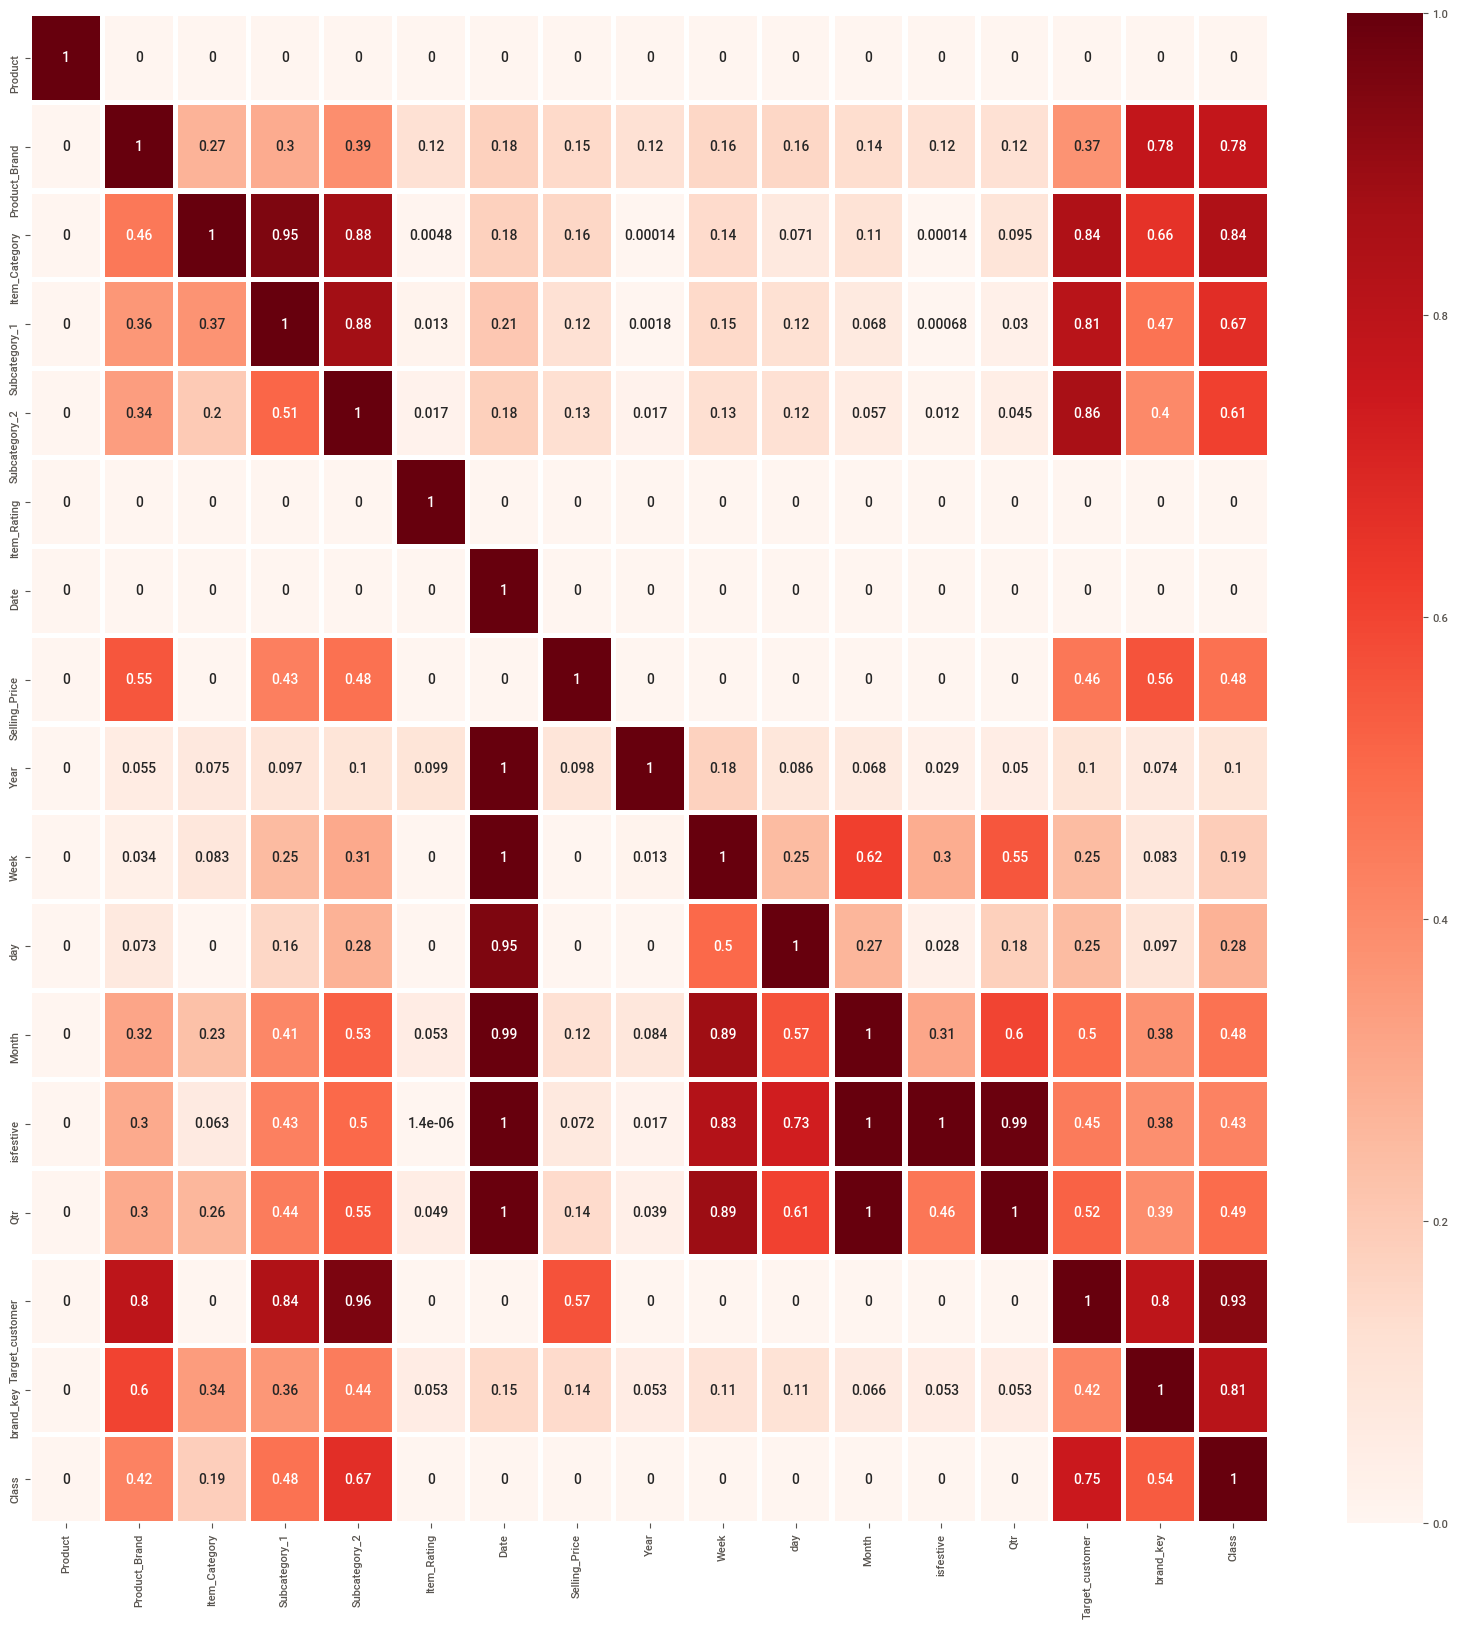

In [324]:
###pps scores detect all types of relationship present in between variables. But if only linear relationship is of interest pearson corr matrix should still be used
df=pps.matrix(df_train)
######################################
fig, ax = plt.subplots(figsize=(20,20)) 
# sns.set(font_scale=1.3)
g=sns.heatmap(df, vmin=0, vmax=1, cmap="Reds", linewidths=3, annot=True,ax=ax,annot_kws={"fontsize":10})

In [0]:
#as can be seen, i was successfull in bringing a high degree of correlation between product brand and class, while class and target_customer both appeared to be imp
#thus we can drop product and product brand for further analysis

In [307]:
df_train.head()

,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date,Selling_Price,Year,Week,day,Month,isfestive,Qtr,brand_key,Class,Target_customer
0,P-2610,B-659,clothing,bags,hand bags,4.3,2017-02-03,291,2017,5,3,2,0,1,clothing_B-659,820,women
1,P-2453,B-3078,clothing,women s clothing,western wear,3.1,2015-07-01,897,2015,27,1,7,0,3,clothing_B-3078,680,men
2,P-6802,B-1810,festive,showpieces,ethnic,3.5,2019-01-12,792,2019,2,12,1,0,1,festive_B-1810,1121,men
3,P-4452,B-3078,clothing,eye care,h2o plus eye care,4.0,2014-12-12,837,2014,50,12,12,1,4,clothing_B-3078,680,unisex
4,P-8454,B-3078,clothing,men s clothing,t shirts,4.3,2013-12-12,470,2013,50,12,12,1,4,clothing_B-3078,680,men


In [0]:

X,Y=df_train.drop(['brand_key','Selling_Price','Date','Subcategory_2','Subcategory_1','Product','Product_Brand'],axis=1),df_train['Selling_Price']
X=pd.get_dummies(X)
X_test=df_test.drop(['brand_key','Date','Subcategory_2','Subcategory_1','Product','Product_Brand'],axis=1)
X_test=pd.get_dummies(X_test)

#prep for catboost 
numerics = ['int64','int32','object']
df_train_cat= df_train.drop(['Product','Product_Brand','brand_key','Selling_Price'],axis=1).select_dtypes(include=numerics)

In [0]:
##after extensive feature selection
gbc_columns=['Class','Target_customer', 'Item_Category_festive',
       'Item_Category_furniture', 'Item_Category_footwear', 'Month',
       'Item_Category_mobiles accessories', 'Item_Category_clothing',
       'Item_Category_computers', 'Item_Category_pet supplies',
       'Item_Category_home_furnishing',
       'Item_Category_camera', 'Item_Category_baby',
       'Item_Category_watches',
       'Item_Category_home entertainment',
       'isfestive']
xgb_columns=['Class','Target_customer', 'Item_Category_jewellery',
       'Item_Category_kitchen', 'Item_Category_footwear',
       'Item_Category_clothing', 'Month',
       'Item_Category_home_furnishing', 'Item_Category_computers']
cat_columns=['Item_Category', 'Subcategory_1', 'Subcategory_2', 'Year', 'Month',
       'Week', 'day', 'isfestive', 'Qtr',
       'Target_customer', 'Class']

In [0]:
X_GB=X[gbc_columns]
X_XGB=X[xgb_columns]
X_cat=df_train[df_train_cat.columns]
X_GB_test=X_test[gbc_columns]
X_XGB_test=X_test[xgb_columns]
X_cat_test=df_test[df_train_cat.columns]

In [0]:
#hypertuned parameters. full grid was done for xgb and gbr while bayescv was done for catboost. code not included. this was done after feature selection.
train_pool=Pool(df_train_cat,Y,cat_features=[0,1,2])
catboost_model=CatBoostRegressor(bagging_temperature=0.617,border_count=198, 
depth=4, iterations=876,l2_leaf_reg=19,learning_rate=0.154, 
random_strength=0.003,cat_features=[0,1,2],verbose=0)
gbc=GradientBoostingRegressor(learning_rate=0.05,max_depth=7, n_estimators=100, subsample=0.7)
xgb=XGBRegressor(learning_rate=0.03,max_depth=7,min_child_weight=1,n_estimators=200,subsample=0.7,silent=True)

In [313]:
##catboost model test
l=[]

fold = StratifiedKFold(n_splits=10,random_state=True)
scores=[]
for train, test in fold.split(X_cat,Y):
    x_train, x_test = X_cat.values[train], X_cat.values[test]
    y_train, y_test = np.log(Y.values[train]), Y.values[test] 
    model = catboost_model
    model.fit(x_train, y_train)
    preds = np.exp(model.predict(x_test))
    feature_importances = pd.DataFrame(model.feature_importances_,
                                       index = X_cat.columns,
                                        columns=['importance'])
    sum=feature_importances.values
    l.append(sum)
    # preds[preds<0]=0
    score = sqrt(mean_squared_log_error(y_test, preds))
    scores.append(score)
    print(score)
print("Average scores are: ", np.sum(scores)/len(scores))

1.3113131971507608
0.5260382978370307
0.5575112319463054
0.4641511043324526
0.5294980982105372
0.5025909254517653
0.4854011116412182
0.5374081880950864
0.5475865822619607
0.4942594449708505
Average scores are:  0.5955758181897968


In [314]:
#identifying best average features from cv
train_set=df_train_cat
labels=Y
add=0
for item in l:
  add+=item
df_cv=pd.DataFrame(add/len(l),index=train_set.columns,columns=["importance"]).sort_values('importance', ascending=False)
df_cv=df_cv.reset_index()
feat_imp = pd.Series(df_cv.importance.values, index=df_cv.drop(["importance"], axis=1)).sort_values(axis='index',ascending=False)
# 
feat_imp2=feat_imp[feat_imp>0.00005]
imp_columns=[]
for item in pd.DataFrame(feat_imp2).reset_index()["index"].tolist():
  f=re.sub("[(),]","",str(item))
  try:  
    columns= int(re.sub("['']","",f))
    imp_columns.append(columns)
  except:
    columns= re.sub("['']","",f)
    imp_columns.append(columns)
# X_UPDATED=df_train_cat[imp_columns]
len(imp_columns)

11

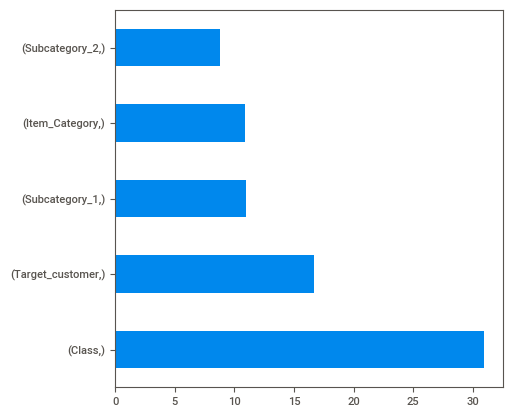

In [316]:
feat_imp.nlargest(5).plot(kind='barh', figsize=(5,5))


In [318]:
#testing for gradient boosting regressor
l=[]

fold = StratifiedKFold(n_splits=10,random_state=True)
scores=[]
for train, test in fold.split(X_GB,Y):
    x_train, x_test = X_GB.values[train], X_GB.values[test]
    y_train, y_test = np.log(Y.values[train]), Y.values[test] 
    model = gbc
    model.fit(x_train, y_train)
    preds = np.exp(model.predict(x_test))
    feature_importances = pd.DataFrame(model.feature_importances_,
                                       index = X_GB.columns,
                                        columns=['importance'])
    sum=feature_importances.values
    l.append(sum)
    # preds[preds<0]=0
    score = sqrt(mean_squared_log_error(y_test, preds))
    scores.append(score)
    print(score)
print("Average scores are: ", np.sum(scores)/len(scores))

1.3447614380898902
0.5295481773628165
0.5388362314124157
0.41331761635064623
0.5048482107611507
0.45335508940853253
0.46342355885344044
0.5878224144853352
0.5402580785547298
0.555226046644268
Average scores are:  0.5931396861923225


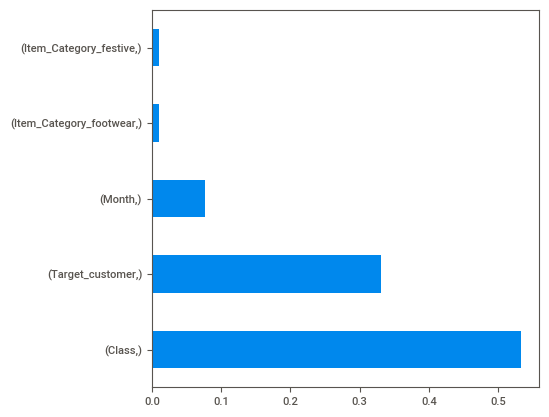

In [320]:
train_set=X_GB
labels=Y
add=0
for item in l:
  add+=item
df_cv=pd.DataFrame(add/len(l),index=train_set.columns,columns=["importance"]).sort_values('importance', ascending=False)
df_cv=df_cv.reset_index()
feat_imp = pd.Series(df_cv.importance.values, index=df_cv.drop(["importance"], axis=1)).sort_values(axis='index',ascending=False)
# 
feat_imp2=feat_imp[feat_imp>0.00005]
imp_columns=[]
for item in pd.DataFrame(feat_imp2).reset_index()["index"].tolist():
  f=re.sub("[(),]","",str(item))
  try:  
    columns= int(re.sub("['']","",f))
    imp_columns.append(columns)
  except:
    columns= re.sub("['']","",f)
    imp_columns.append(columns)
# X_UPDATED=X_GB[imp_columns]
len(imp_columns)
feat_imp.nlargest(5).plot(kind='barh', figsize=(5,5))


In [321]:
#testing for xgbregressor
l=[]
fold = StratifiedKFold(n_splits=10,random_state=True)
scores=[]
for train, test in fold.split(X_XGB,Y):
    x_train, x_test = X_XGB.values[train], X_XGB.values[test]
    y_train, y_test = np.log(Y.values[train]), Y.values[test] 
    model = xgb
    model.fit(x_train, y_train)
    preds = np.exp(model.predict(x_test))
    feature_importances = pd.DataFrame(model.feature_importances_,
                                       index = X_XGB.columns,
                                        columns=['importance'])
    sum=feature_importances.values
    l.append(sum)
    # preds[preds<0]=0
    score = sqrt(mean_squared_log_error(y_test, preds))
    scores.append(score)
    print(score)
print("Average scores are: ", np.sum(scores)/len(scores))

1.44808729277513
0.5338046744731467
0.5227674149666978
0.4390334710655028
0.48064584690288537
0.4509598915425695
0.4577327542796703
0.571754400229372
0.5435546463769801
0.48830895918835565
Average scores are:  0.5936649351800309


In [0]:
pred_gbc=gbc.predict(X_GB_test.values)
pred_xgb=xgb.predict(X_XGB_test.values)
pred_cat=catboost_model.predict(X_cat_test.values)
solution=pd.DataFrame()
solution['gbc']=pred_gbc
solution['xgb']=pred_xgb
solution['cat']=pred_cat

In [0]:
solution['Selling_Price']=0.2*solution['cat']+0.4*solution['xgb']+0.4*solution['gbc']
solution['Selling_Price'].to_csv("finalsolution.csv")